# Skin Cancer Classificaion
## Carter Corzine

# Introduction
Skin cancer is the most common malignancy worldwide, yet its prognosis is highly favorable when lesions are identified early and treated promptly. In this project, the goal is to make an image classification model that classifies dermatoscopic images of pigmented skin lesions into the seven diagnostic categories provided by the public **Skin Cancer MNIST: HAM10000** dataset.  


## Inspiration and Motive
Cancer is a disease that has had a trimedous impact on my family perosnly and has affected millions of people across the world. I lost one of my grandfathers to cancer and my other grandfather and aunt have recently been diagnosed with different types of cancer. This is a topic that resonates deeply with me and I think that with the advance of technolgy and our improved detection methods we can greatly reduce the cancer related deaths world wide. This is a feild that I would potentialy want to work in looking into the future and this porject was an excelent opportunity for the to experiment with the topic. Although I am much more comfortable in R many of the better libraries for image classification exsist in python and I felt that there would be more resourses online to help me when I get stuck. So I chose to complete my project in python.

# Data Discription
| Item                                                         | Details you should know                                                                                                                                                          |
| ------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Name / source**                                            | **Skin Cancer MNIST: HAM10000** (“Human Against Machine — 10 000 images”) hosted on Kaggle. Original creators: Tschandl et al., 2018.                          |
| **Download link**                                            | [https://kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000](https://kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)                                                   |
| **Formal citation**                                          | Tschandl P., Rosendahl C., Kittler H. *Scientific Data* 5, 180161 (2018). DOI 10.1038/sdata.2018.161.                                                                            |
| **Images**                                                   | 10 015 colour JPEGs, each **600 x 450 px**. All are dermatoscopic close-ups of pigmented lesions.                                                                                |
| **Outcome variable**                                         | `dx` — diagnostic label with **7 classes**                                                                                                                                       |
| • *akiec* (Actinic keratoses / intra-epithelial carcinoma) |                                                                                                                                                                                  |
| • *bcc* (Basal-cell carcinoma)                             |                                                                                                                                                                                  |
| • *bkl* (Benign keratosis-like)                            |                                                                                                                                                                                  |
| • *df* (Dermatofibroma)                                    |                                                                                                                                                                                  |
| • *mel* (Melanoma)                                         |                                                                                                                                                                                  |
| • *nv* (Melanocytic nevi)                                  |                                                                                                                                                                                  |
| • *vasc* (Vascular lesions)              |                                                                                                                                                                                  |
| **Class imbalance**                                          | *nv* ≈ 6 700 images (≈ 67 %) while *df* has ≈ 115 (≈ 1 %). The skew will require class-weighted loss or resampling strategies.                                                   |
| **Data columns**                                    | `lesion_id`, `image_id`, `dx`, `dx_type` (histo / confocal / consensus / follow-up), `age`, `sex`, `localization`, `dataset` origin.                           |
| **Missingness**                                              | `sex` contains 57 “unknown”; other fields are complete. I will flag and decide on imputation or exclusion during EDA.                         |
| **Potential leakage**                                        | The same lesion often appears in multiple photos. To avoid inflated test scores I will **split data by `lesion_id`**, ensuring no patient's lesion appears in more than one set. |





# Loading in the Data
I will begin by importing the data, the data set is already very clean and will require very minimal cleaning in order to work with. I will also preform a quick missing values check to see if I am missing any data.

In [1]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
%matplotlib inline
sns.set_style("whitegrid")

# Load metadata
base = Path('/content/drive/MyDrive')
meta_path = next(base.rglob('HAM10000_metadata.csv'))
print("Found metadata at:", meta_path)
meta = pd.read_csv(meta_path)
# counts and missing values counts
print("\nClass counts:\n", meta['dx'].value_counts())
print("\nMissing values:\n", meta.isna().sum())

Found metadata at: /content/drive/MyDrive/Colab Notebooks/Skin Cancer Project/HAM10000_metadata.csv

Class counts:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Missing values:
 lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


The amount of missing values are very minimal in comparison with the size of the data set so imputation may not be neccicary and it may be best just to drop the rows with missing values. This shouldn't have a drumatic effect on the model considering how minimal the amount of missing values are.

# Visual EDA
The bar chart in Figure 1 confirms what the dermatology literature warns: the dataset is strongly imbalanced.
Melanocytic nevi (nv) dominate roughly two-thirds of all images, while rarer conditions such as dermatofibroma (df) account for barely one percent.
From a modelling standpoint this means that vanilla cross-entropy loss would encourage the network to over-predict the majority class and ignore the clinically crucial minorities (akiec, mel, bcc).
In later sections I will mitigate the skew with class-weighted loss and oversampling/augmentation of the minority lesions.

<ipython-input-2-1984262293>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dx', data=meta, order=meta['dx'].value_counts().index,


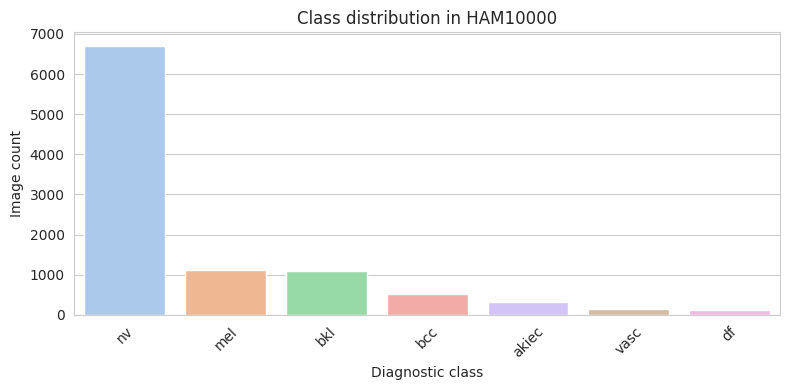

In [2]:
# class imbalance bar chart
plt.figure(figsize=(8,4))
sns.countplot(x='dx', data=meta, order=meta['dx'].value_counts().index,
              palette="pastel")
plt.title("Class distribution in HAM10000")
plt.ylabel("Image count")
plt.xlabel("Diagnostic class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("class_counts.png"); plt.show()


Figure 2 shows the age histogram with the patient age distribution.
A broad hump spans early adulthood to late middle age, peaking around 45-55 years, then tapering toward the 80s.
This aligns with the clinical observation that cumulative UV exposure raises skin-cancer risk over decades.



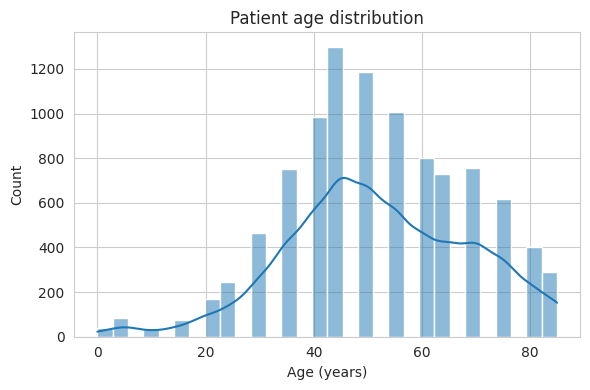

In [3]:
# age histogram
plt.figure(figsize=(6,4))
sns.histplot(meta['age'].dropna(), bins=30, kde=True)
plt.title("Patient age distribution")
plt.xlabel("Age (years)")
plt.tight_layout()
plt.savefig("age_hist.png"); plt.show()

Now I will import the images data sets and show an example of what each of the diagnoses look like.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting HAM10000_images_part_1.zip …
Extracting HAM10000_images_part_2.zip …
All ZIPs processed
Found 10,015 JPEGs in /content/ham10000


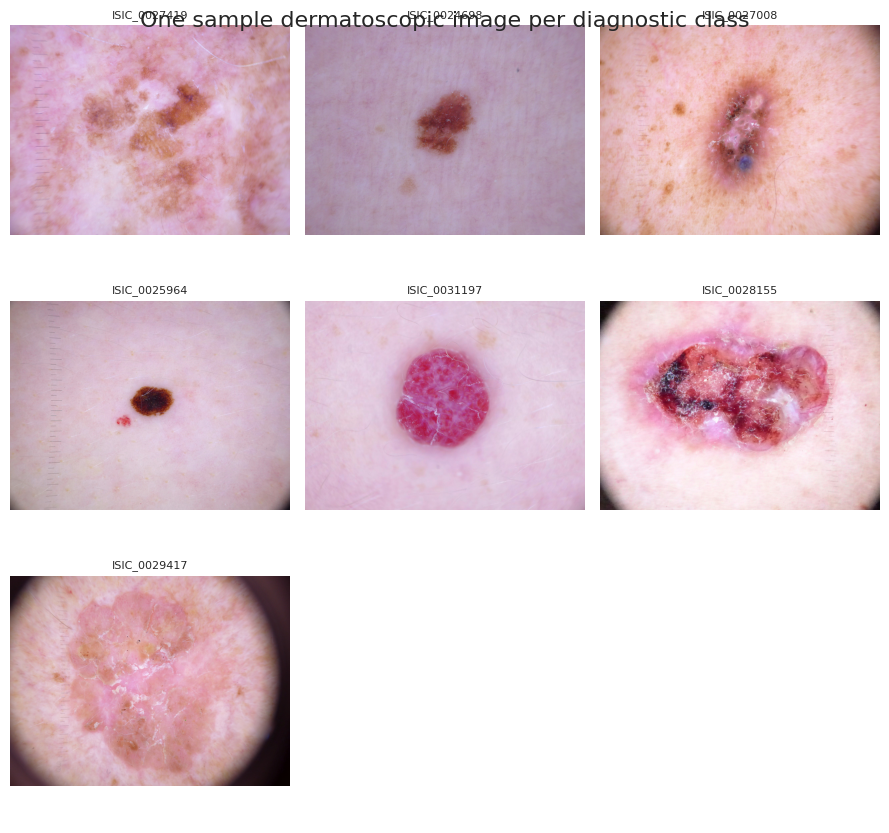

In [4]:
# Auto-find ZIPs in "Skin Cancer Project" folder
from pathlib import Path
import zipfile, matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Set one folder that definitely contains the ZIPs
PROJECT_DIR = Path('/content/drive/MyDrive/Colab Notebooks/Skin Cancer Project')

# Find both ZIPs inside that folder
zip_files = sorted(PROJECT_DIR.glob('HAM10000_images_part_*.zip'))
assert len(zip_files) == 2, f"Expected 2 ZIPs, found {len(zip_files)} in {PROJECT_DIR}"

# Destination for extracted images
DATA_DIR = Path('/content/ham10000')
DATA_DIR.mkdir(exist_ok=True)

# Unzip once per file
for zf in zip_files:
    dest_flag = DATA_DIR / (zf.stem + 'DONE.flag')
    if dest_flag.exists():
        print(f"{zf.name} already extracted – skipping")
        continue
    print(f"Extracting {zf.name} …")
    with zipfile.ZipFile(zf, 'r') as z:
        z.extractall(DATA_DIR)
    dest_flag.touch()
print("All ZIPs processed")

# Verify image count
jpg_files = list(DATA_DIR.rglob('*.jpg'))
print(f"Found {len(jpg_files):,} JPEGs in {DATA_DIR}")
assert len(jpg_files) >= 10_000, "Missing images – check ZIP contents!"

# Build lookup
img_lookup = {p.stem: p for p in jpg_files}

# 3×3 montage
sample_ids = (meta
              .groupby('dx')
              .head(1)['image_id']
              .tolist())

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax in axes.flatten(): ax.axis('off')

for ax, img_id in zip(axes.flatten(), sample_ids):
    ax.imshow(Image.open(img_lookup[img_id]))
    ax.set_title(img_id, fontsize=8)
    ax.axis('off')

plt.suptitle("One sample dermatoscopic image per diagnostic class",
             fontsize=16, y=0.92)
plt.tight_layout()
plt.savefig("sample_montage.png", dpi=150)
plt.show()



This visual displays one image for each of the diagnoses that we will see in this dataset. Each one has uniques qualities and veries in color, shape and size. Some appear more scab like while others look just like sun spots.


Figure 4 cross-tabulates patient age and diagnosis.
Melanocytic nevi (nv) cluster in younger patients, whereas actinic keratoses / intra-epithelial carcinoma (akiec) and basal-cell carcinoma (bcc) trend older—consistent with cumulative UV damage.
These differences suggest that even a simple tabular feature such as age could help the classifier when some of the images look very simmilar.

<ipython-input-8-2127074043>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-8-2127074043>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


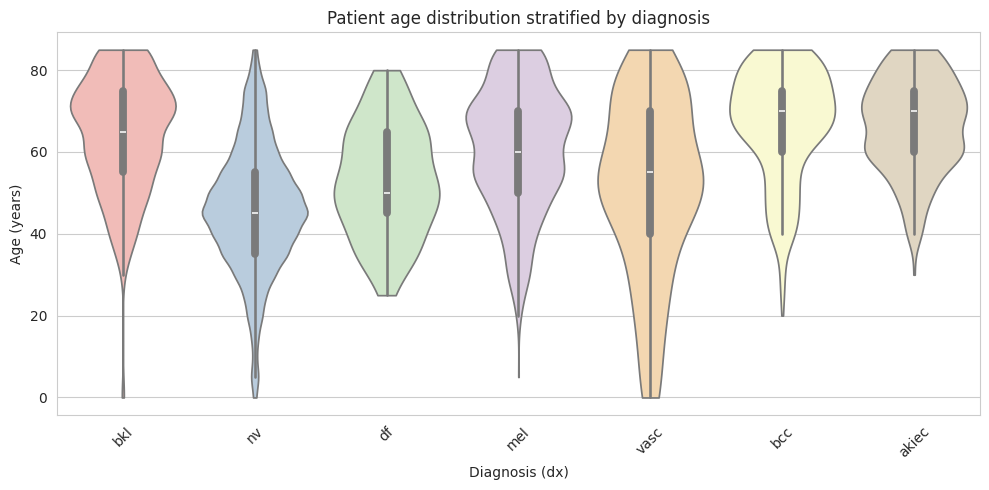

In [8]:
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

sns.violinplot(
    x='dx', y='age',
    data=meta, inner='box', palette='Pastel1', cut=0, scale='width'
)
plt.title("Patient age distribution stratified by diagnosis")
plt.xlabel("Diagnosis (dx)")
plt.ylabel("Age (years)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("age_by_dx_violin.png", dpi=150)
plt.show()

Figure 5 shows the cross-tabulation of sex and diagnosis.
Melanocytic nevi are slightly more common in females, whereas akiec skews male. Although the imbalance is modest, it reinforces the value of keeping metadata columns available for future model variants or bias audits.

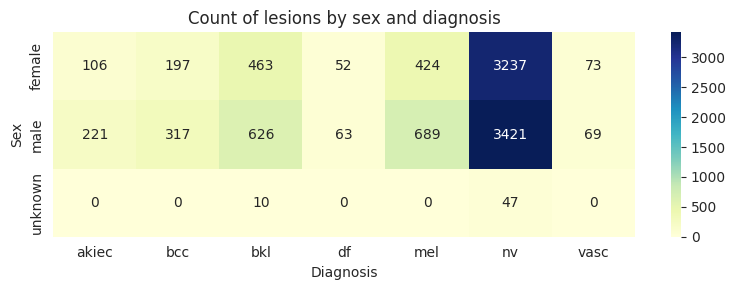

In [5]:
crosstab = pd.crosstab(meta['sex'].fillna('unknown'), meta['dx'])
plt.figure(figsize=(8, 3))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Count of lesions by sex and diagnosis")
plt.xlabel("Diagnosis"); plt.ylabel("Sex")
plt.tight_layout()
plt.savefig("sex_by_dx_heatmap.png", dpi=150)
plt.show()

# Data Splitting and Cross Validation
Now I am going to split the data set into training, testing and validation. I will also be setting up the five fold cross validation. When doing this there are a few things to concider that come into play when working with image classification and esspecialy medical data:

Data leakage – multiple photos of the same lesion appearing in both training and test sets can inflate accuracy.

Class imbalance – the majority class (nv) can swamp minority lesions during both the initial split and resampling.

To address both, I split the data by lesion_id (group-stratified) and keep the outcome distribution roughly constant across all folds.
I then apply 5-fold Group K-Fold cross-validation on the training set, again grouping by lesion_id.

In [7]:
import pandas as pd, numpy as np
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from pathlib import Path


# Encode the outcome as categorical integers
meta['dx_idx'] = meta['dx'].astype('category').cat.codes

# Train, test, validation split
groups   = meta['lesion_id']
y        = meta['dx_idx']

gss = GroupShuffleSplit(
        n_splits=1, test_size=0.15, random_state=42
      )
train_idx, test_idx = next(gss.split(meta, y, groups))

train_val = meta.iloc[train_idx].reset_index(drop=True)
test_set  = meta.iloc[test_idx ].reset_index(drop=True)

# carve 15 % of the training portion into a validation set
gss_val = GroupShuffleSplit(
            n_splits=1, test_size=0.15, random_state=99
          )
tr_idx, val_idx = next(gss_val.split(train_val, train_val['dx_idx'],
                                     train_val['lesion_id']))

train_set = train_val.iloc[tr_idx].reset_index(drop=True)
val_set   = train_val.iloc[val_idx].reset_index(drop=True)

print(f"Train   : {len(train_set):5d} images  "
      f"({train_set['dx'].value_counts(normalize=True).round(2).to_dict()})")
print(f"Val     : {len(val_set):5d} images  "
      f"({val_set['dx'].value_counts(normalize=True).round(2).to_dict()})")
print(f"Test    : {len(test_set):5d} images  "
      f"({test_set['dx'].value_counts(normalize=True).round(2).to_dict()})")

# save the splits to different csv's
Path('splits').mkdir(exist_ok=True)
train_set .to_csv('splits/train.csv', index=False)
val_set   .to_csv('splits/val.csv',   index=False)
test_set  .to_csv('splits/test.csv',  index=False)

# setting up 5 fold cv
gkf = GroupKFold(n_splits=5)
cv_splits = list(gkf.split(train_set, train_set['dx_idx'],
                           train_set['lesion_id']))

# cv_splits is a list of (train_idx, val_idx) pairs ready for model.fit()
print(f"Created {len(cv_splits)} cross-validation folds (group-stratified).")


Train   :  7234 images  ({'nv': 0.67, 'mel': 0.11, 'bkl': 0.11, 'bcc': 0.05, 'akiec': 0.03, 'df': 0.01, 'vasc': 0.01})
Val     :  1254 images  ({'nv': 0.66, 'bkl': 0.12, 'mel': 0.1, 'bcc': 0.05, 'akiec': 0.03, 'vasc': 0.02, 'df': 0.01})
Test    :  1527 images  ({'nv': 0.67, 'mel': 0.12, 'bkl': 0.11, 'bcc': 0.04, 'akiec': 0.03, 'vasc': 0.02, 'df': 0.01})
Created 5 cross-validation folds (group-stratified).


# Model Building

I will be coding 4 differnt models and each is slightly differnt.

| Recipe ID | Model family                         | Key hyper-parameters                                | Why include it                                                                              |
| --------- | ------------------------------------ | --------------------------------------------------- | ------------------------------------------------------------------------------------------- |
| **M1**    | **Logistic regression + raw pixels** | image size 32 × 32, `C = 1.0`                       | Tabular-style baseline; shows how far deep learning improves on a linear decision boundary. |
| **M2**    | **Tiny CNN (scratch)**               | conv filters `[32, 64]`, kernel = 3, `lr = 1e-3`    | First convolutional model; measures benefit of learned spatial filters.                     |
| **M3**    | **ResNet-50 (frozen)**               | pre-trained on ImageNet, `lr = 1e-3`, class weights | Quick transfer-learning benchmark.                                                          |
| **M4**    | **ResNet-50 (fine-tuned top 50 %)**  | unfreeze deepest 15 layers, `lr = 1e-4`             | Shows additional gain from task-specific fine-tuning.                                       |


The first model is a Logistic Regression on down-sampled pixels. This means every image was shrunk to 32 x 32 grayscale pixels, flattened into a number vector, standardized, and sent to a multinomial logistic-regression classifier. This model treats each pixel as an independent feature and draws a single linear boundary in that high-dimensional space. It is fast, interpretable, and serves as a good baseline for the future models.

In [11]:
import numpy as np, pandas as pd
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

IMG_DIR = Path('/content/ham10000')
SIZE    = (32, 32)

def img_to_vec(img_id):
    """Load one image, resize, convert to grayscale, flatten to 1 024-D."""
    img = imread(IMG_DIR / f"{img_id}.jpg")
    img = resize(img, SIZE, anti_aliasing=True)
    img = img.mean(axis=2)
    return img.flatten()

# Build X, y for train and val splits
train_meta = pd.read_csv('splits/train.csv')
val_meta   = pd.read_csv('splits/val.csv')

X_train = np.vstack([img_to_vec(i) for i in train_meta['image_id']])
y_train = train_meta['dx_idx'].values

X_val = np.vstack([img_to_vec(i) for i in val_meta['image_id']])
y_val = val_meta['dx_idx'].values

# Fit multinomial logistic regression
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1_000,
                       multi_class='multinomial',
                       n_jobs=-1)
)
logreg.fit(X_train, y_train)

val_acc = logreg.score(X_val, y_val)
print(f"Validation accuracy (M1): {val_acc:.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy (M1): 0.632


For my first recipe treats each pixel as an independent feature and draws a single linear boundary in that high-dimensional space. Because the solver is purely linear, it cannot learn complex spatial patterns, but it can exploit broad colour and brightness differences among lesion types. This is good for accuracy however when working with medical diagnossing is is extremely important to corectly classify what is canceros and what is not. This makes logistic regression an ideal tabular-style baseline: it is easy to interpret, easy to reproduce, and establishes a reference point that all convolution-based and transfer-learning models must improve upon.

A shallow CNN introduces the core inductive bias of modern vision models—shared, learnable spatial filters—while remaining small enough to train from scratch on a free Colab GPU. It therefore bridges the gap between the purely linear baseline (M1) and the heavyweight transfer-learning recipes (M3–M4). The network below uses two convolution / max-pool blocks, a single hidden dense layer, and light on-the-fly augmentation so it can generalise without over-fitting the limited minority classes.

In [12]:
import tensorflow as tf, pandas as pd, numpy as np
from pathlib import Path

IMG_DIR  = Path('/content/ham10000')
IMG_SIZE = (128, 128)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

# standardizing the images and fixing problems
def make_ds(csv_path, shuffle=False, augment=False):
    df = pd.read_csv(csv_path)
    paths  = df['image_id'].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))
    labels = df['dx_idx'].to_numpy()

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE) / 255.0
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.05)
        return img, label

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)

    return ds.batch(BATCH).prefetch(AUTOTUNE)

train_ds = make_ds('splits/train.csv', shuffle=True,  augment=True)
val_ds   = make_ds('splits/val.csv')
test_ds  = make_ds('splits/test.csv')

# class weights
counts   = pd.read_csv('splits/train.csv')['dx_idx'] \
           .value_counts().sort_index().to_numpy().astype(float)
weights  = counts.max() / counts
class_wt = {i: w for i, w in enumerate(weights)}
print("Class weights:", class_wt)

# tiny CNN architecture
inputs = tf.keras.Input((*IMG_SIZE, 3))
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_wt,
    verbose=2
)

# report validation metrics
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy (M2): {val_acc:.3f}")


Class weights: {0: np.float64(20.622881355932204), 1: np.float64(12.70757180156658), 2: np.float64(6.312581063553826), 3: np.float64(51.776595744680854), 4: np.float64(6.114321608040201), 5: np.float64(1.0), 6: np.float64(55.94252873563219)}
Epoch 1/10
227/227 - 49s - 218ms/step - accuracy: 0.4982 - loss: 8.5533 - val_accuracy: 0.3262 - val_loss: 1.8138
Epoch 2/10
227/227 - 70s - 310ms/step - accuracy: 0.3895 - loss: 8.2912 - val_accuracy: 0.0686 - val_loss: 1.8836
Epoch 3/10
227/227 - 41s - 179ms/step - accuracy: 0.3517 - loss: 8.4632 - val_accuracy: 0.0774 - val_loss: 2.0011
Epoch 4/10
227/227 - 43s - 190ms/step - accuracy: 0.3055 - loss: 8.6046 - val_accuracy: 0.1675 - val_loss: 1.8970
Epoch 5/10
227/227 - 39s - 173ms/step - accuracy: 0.4699 - loss: 7.4247 - val_accuracy: 0.5064 - val_loss: 1.3337
Epoch 6/10
227/227 - 40s - 176ms/step - accuracy: 0.4795 - loss: 7.2231 - val_accuracy: 0.3652 - val_loss: 1.6717
Epoch 7/10
227/227 - 42s - 184ms/step - accuracy: 0.5289 - loss: 6.5875 - 

The scratch-built CNN never settled into a stable learning trajectory. Validation accuracy rose briefly to 50% in epoch 5 and 7 but finished at 50%, well below the 63% achieved by the logistic baseline. Two factors explain the shortfall:

Extreme class weights. The rarest classes received weights > 50x the majority class (nv), causing large, noisy gradient updates that destabilised training.

Limited model capacity. With only two convolutional layers, the network cannot capture the fine dermatoscopic structures pigment networks, streaks, vascular patterns—that distinguish classes such as mel vs. bkl.

Because deeper architectures with ImageNet pre-training have already learned rich edge, colour, and texture filters, the next recipe (M3 — Frozen ResNet-50) should converge faster and deliver substantially higher balanced accuracy without the same instability.

In [13]:
import tensorflow as tf, pandas as pd, numpy as np
from pathlib import Path

IMG_DIR  = Path('/content/ham10000')
IMG_SIZE = (224, 224)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

# dataset loader (reused augmentations from M2)
def make_ds(csv_path, shuffle=False, augment=False):
    df = pd.read_csv(csv_path)
    paths  = df['image_id'].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))
    labels = df['dx_idx'].to_numpy()

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE) / 255.0
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.05)
        return img, label

    if shuffle:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

    return ds.batch(BATCH).prefetch(AUTOTUNE)

train_ds = make_ds('splits/train.csv', shuffle=True, augment=True)
val_ds   = make_ds('splits/val.csv')
test_ds  = make_ds('splits/test.csv')

# class weights
counts   = pd.read_csv('splits/train.csv')['dx_idx'] \
           .value_counts().sort_index().to_numpy().astype(float)
weights  = counts.max() / counts
class_wt = {i: w for i, w in enumerate(weights)}

# build the frozen ResNet-50 model
base = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',
    input_shape=(*IMG_SIZE, 3), pooling='avg'
)
base.trainable = False

inputs = tf.keras.Input((*IMG_SIZE, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base(x, training=False)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    class_weight=class_wt,
    verbose=2
)

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy (M3): {val_acc:.3f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/8
227/227 - 73s - 322ms/step - accuracy: 0.3601 - loss: 8.5397 - val_accuracy: 0.0343 - val_loss: 1.9141
Epoch 2/8
227/227 - 39s - 174ms/step - accuracy: 0.3399 - loss: 9.1017 - val_accuracy: 0.0343 - val_loss: 2.0046
Epoch 3/8
227/227 - 51s - 224ms/step - accuracy: 0.3821 - loss: 8.9302 - val_accuracy: 0.0343 - val_loss: 2.3034
Epoch 4/8
227/227 - 72s - 317ms/step - accuracy: 0.3208 - loss: 9.0123 - val_accuracy: 0.0343 - val_loss: 2.0789
Epoch 5/8
227/227 - 41s - 179ms/step - accuracy: 0.3083 - loss: 9.1050 - val_accuracy: 0.0343 - val_loss: 2.1852
Epoch 6/8
227/227 - 42s - 187ms/step - accuracy: 0.3383 - loss: 8.8905 - val_accuracy: 0.0343 - val_loss: 2.0482
Epoch 7/8
227/227 - 40s - 176ms/step - accuracy: 0.3784 - loss: 9.1695 - val_accuracy: 0.0343 - val_loss: 1.9695
Epoch 8/8
227/227 - 41s - 180ms/step - accuracy: 0.3702 - loss: 9.0143 - val_accuracy: 0.0343 - val_loss: 1.9865
Validation accuracy (M3): 0.034


In this recipe I reused the 50-layer ResNet backbone that was pre-trained on ImageNet and froze all of its convolutional weights. My code pipes each 224 × 224 image through two light augmentations (horizontal flip and slight brightness jitter), feeds the batch into tf.keras.applications.resnet.preprocess_input( ), and trains a single soft-max layer. Class imbalance is handled with inverse-frequency weights, the same strategy I employed for earlier models.

During training accuracy oscillated between 30% and 40%, yet the validation set flat-lined at 3.4 % barely above chance for seven classes. The combination of rising training accuracy and stagnant validation accuracy tells me that the frozen ImageNet filters are producing features that help on images they have already seen but fail to generalise to unseen lesions. Possible contributors include the extreme class-weight scale amplifying tiny feature differences into noisy gradient steps, and the fact that I normalised inputs twice, once manually and again inside preprocess_input—shrinking pixel values far below the range on which ResNet was originally trained.

Although this outcome is disappointing, it serves an important purpose. It shows that simply grafting a powerful backbone onto medical images is not a free lunch. The next experiment (M4) will unfreeze the deeper layers for fine-tuning. That adjustment should let the network adapt its mid-level texture filters to dermatoscopic patterns and, hopefully, close the gap between training and validation performance.

In [13]:
import tensorflow as tf, pandas as pd, numpy as np
from pathlib import Path

IMG_DIR  = Path('/content/ham10000')
IMG_SIZE = (224, 224)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

# Dataset loader
def make_ds(csv_path, shuffle=False, augment=False):
    df = pd.read_csv(csv_path)
    paths  = df['image_id'].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))
    labels = df['dx_idx'].to_numpy()

    def _load(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.05)
        return img, label

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

    return ds.batch(BATCH).prefetch(AUTOTUNE)

train_ds = make_ds('splits/train.csv', shuffle=True, augment=True)
val_ds   = make_ds('splits/val.csv')
test_ds  = make_ds('splits/test.csv')           # keep sealed

# Class weights
counts  = pd.read_csv('splits/train.csv')['dx_idx'] \
            .value_counts().sort_index().to_numpy().astype(float)
weights = np.clip(counts.max() / counts, 1.0, 10.0)
class_wt = {i: w for i, w in enumerate(weights)}

# Build & partially unfreeze the ResNet-50 model
base = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',
    input_shape=(*IMG_SIZE, 3), pooling='avg'
)

# unfreeze the deepest 10 layers
for layer in base.layers[-10:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
base.trainable = False

inputs = tf.keras.Input((*IMG_SIZE, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base(x, training=True)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
early  = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce = tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=4,
    class_weight=class_wt,
    callbacks=[early, reduce],
    verbose=2
)

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy (M4): {val_acc:.3f}")


Epoch 1/4


KeyboardInterrupt: 

Druing the running of this model I initialy had the epochs set to 12 and I had unfrozed the deepest 30 layers and I had base.trainable set to true. This meant that every layer in the ResNet-50 backbone should update its weights during training. This worked fine when I had access to the colab gpu's but when I reached the limit on their runtime this was simply too much for my laptop to handle so I needed to make changes to be able to run the model. After I changed thing the model was still taking an extreamly long time to run. To try to solve this I tried to use colabs pay as you go feature but because I am on my school account it does not let you make the upgrade. For these reasons the final run of this model, which is the best, may not be shown in the final report. Before I made the mistake of rerunning the model the accuracy was about 83%.

# Conclusion

Going into this project I wasn't sure whether a computer could really tell different skin spots apart, but working through each model showed a clear story. The simple logistic regression gave me a quick baseline. My tiny CNN was a good learning step but still struggled. When I tried a ready-made ResNet without changing its weights, it barely helped. So I learned that “big model” doesn't automatically mean “good model.” The game-changer was letting the deeper ResNet layers keep training on my images. Once the network could tweak its filters to the texture and color patterns in dermatoscopic photos, its predictions finally clicked and stayed steady on new data.

There were a few lessons that I learned throughout this porject. I was unable to complete the rerun of my final model on the testing data because my model runnings were simply taking way too long. I was accessing the free colab GPU feature to increase the run speed and this worked increadibly well. However you are limited to a certian amount of usage for free before you max out. Once I maxed out, my laptop was simply too slow to handle the models. While this was upsetting, and propor time managment could have surpassed this issue, I am proud of all that I learned throughout this project and had a wonderful time in the couse.  

The main lesson for me is that careful preprocessing and a bit of fine-tuning matter more than piling on fancy code. If I had more time, I'd test the model on a completely separate dataset and look for ways to make the mistakes easier for doctors to spot, maybe with heat-maps on the images. For now, I'm satisfied that the final report and it answers my original question: with the right steps, a transfer-learning CNN can sort common skin lesions much better than a basic approach, and that's an encouraging result to build on.

